In [1]:
import jax
print("JAX path:", jax.__file__)

JAX path: /Users/yuxin/miniconda3/lib/python3.12/site-packages/jax/__init__.py


In [2]:
## load module
import bstpp
import numpy as np
import numpyro 
import numpyro.distributions as dist
import pandas as pd
import geopandas as gpd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install torch
import torch
from shapely.geometry import box
np.random.seed(999)

/Users/yuxin/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from bstpp.main import LGCP_Model, Hawkes_Model, load_Chicago_Shootings, load_Boko_Haram

In [4]:
## set working directory
import os
os.chdir("/Users/yuxin/Dropbox/DDDI/Illegal-Dumping")

## Pre settings

- Cobbs Creek: #e6b422
- Mifflin Square: #F80E07
- Tacony Creek: #19448e
- Fairmount: #543f32

## 311 data preprocessing

In [211]:
## load 2024 data
litter_24 = gpd.read_file('data/311/2024/public_cases_fc.shp')
## filter data
illegal_dumping_24 = litter_24[litter_24['service_na'] == "Illegal Dumping"]

In [178]:
## load 2023 data
litter_23 = gpd.read_file('data/311/2023/public_cases_fc.shp')
## filter data
illegal_dumping_23 = litter_23[litter_23['service_na'] == "Illegal Dumping"]

In [50]:
## load 2022 data
litter_22 = gpd.read_file('data/311/2022/public_cases_fc.shp')
## filter data
illegal_dumping_22 = litter_22[litter_22['service_na'] == "Illegal Dumping"]

In [70]:
## load 2021 data
litter_21 = gpd.read_file('data/311/2021/public_cases_fc.shp')
## filter data
illegal_dumping_21 = litter_21[litter_21['service_na'] == "Illegal Dumping"]

In [194]:
## concact 2022, 2023, and 2024 data
illegal_dumping = pd.concat([illegal_dumping_21,illegal_dumping_22, illegal_dumping_23])
#illegal_dumping = illegal_dumping_23

### Loadding park boundaries

In [88]:
## load philly's city map for mapping
philly_border = gpd.read_file('data/City_Limits/City_Limits.shp')

In [89]:
## load PPR data
ppr =gpd.read_file('parks/PPR/PPR_Properties.geojson')
ppr = ppr.to_crs(4326)

## get Cobbs Creek's map
#obbscreek = ppr[ppr['PARENT_NAME'].str.contains("Cobbs Creek", case=False, na=False)]
cobbscreek = ppr[ppr["OBJECTID"].isin([432])]


## get Mifflin Square's map
mifflin = ppr[ppr["OBJECTID"].isin([208])]

## Tacony
tacony = ppr[ppr["OBJECTID"].isin([10, 64])]

## Fairmount
fairmount = ppr[ppr["OBJECTID"].isin([7, 9])]

/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_4079/28583841.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_4079/28583841.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


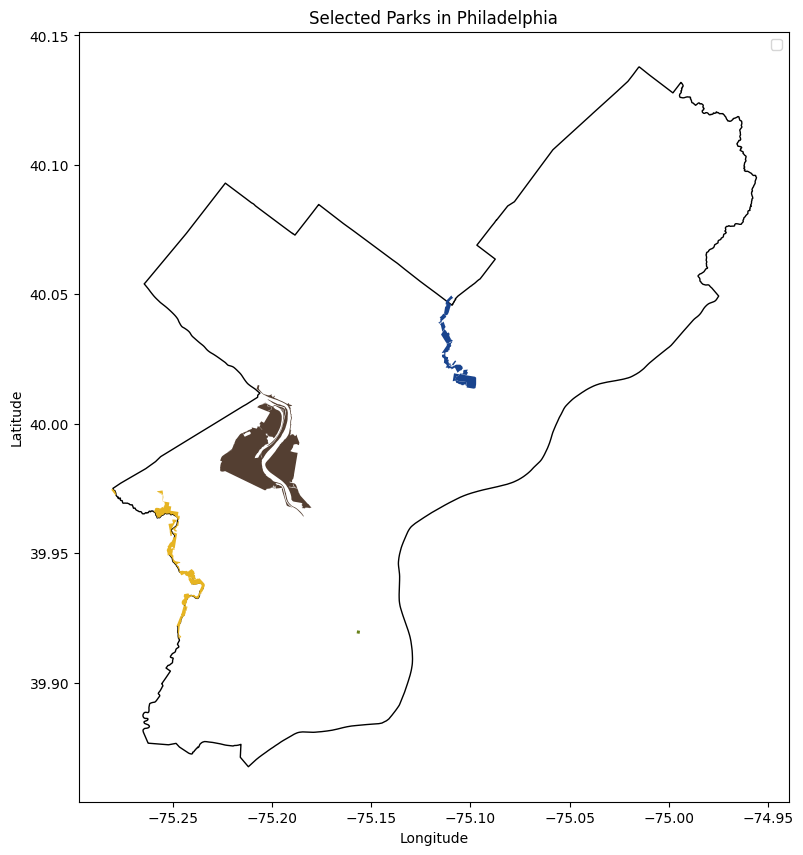

In [90]:
## plot parks within philly
fig, ax = plt.subplots(figsize=(10, 10))

philly_border.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
cobbscreek.plot(ax=ax, color='#e6b422', label='Cobbs Creek')
mifflin.plot(ax=ax, color='#69821b', label='Mifflin Square')
tacony.plot(ax=ax, color='#19448e', label='Tacony')
fairmount.plot(ax=ax, color='#543f32', label='Fairmount')

plt.legend()
plt.title('Selected Parks in Philadelphia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Setting boxes around parks

In [91]:
## list of parks
parks = {
    'cobbscreek': cobbscreek,
    'mifflin': mifflin,
    'tacony': tacony,
    'fairmount': fairmount
}

# set buffer value
buffer = 0.003

# collect results
all_parks_gdf = gpd.GeoDataFrame() # for plotting
all_boxes_gdf = gpd.GeoDataFrame() # for filtering

# loop: get boxes around 
for name, gdf in parks.items():
    # skip empty GeoDataFrames
    if gdf.empty:
        continue
    
    # store parks geometries
    all_parks_gdf = pd.concat([all_parks_gdf, gdf], ignore_index=True)

    # compute total bounds
    minx, miny, maxx, maxy = gdf.total_bounds
    minx -= buffer
    maxx += buffer
    miny -= buffer
    maxy += buffer

    # compute the side length of the square
    side = max(maxx - minx, maxy - miny)
    center_x = (minx + maxx) / 2
    center_y = (miny + maxy) / 2

    # create square box
    square_minx = center_x - side / 2
    square_maxx = center_x + side / 2
    square_miny = center_y - side / 2
    square_maxy = center_y + side / 2
    square_geom = box(square_minx, square_miny, square_maxx, square_maxy)

    # create GeoDataFrame for box
    square_gdf = gpd.GeoDataFrame(
        {'PARKNAME': [f"{name}_box"]},
        geometry=[square_geom],
        crs=gdf.crs
    )

    # add box to collection
    all_boxes_gdf = pd.concat([all_boxes_gdf, square_gdf], ignore_index=True)

<Axes: >

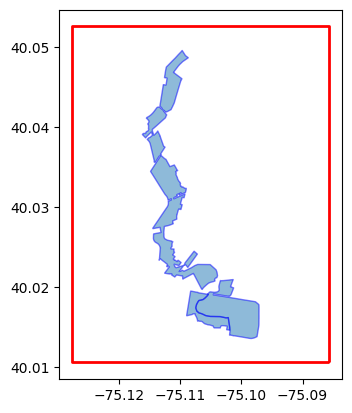

In [92]:
## check results by plotting
ax = tacony.plot(edgecolor='blue', alpha=0.5)
all_boxes_gdf[all_boxes_gdf['PARKNAME']=="tacony_box"].plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)

<Axes: >

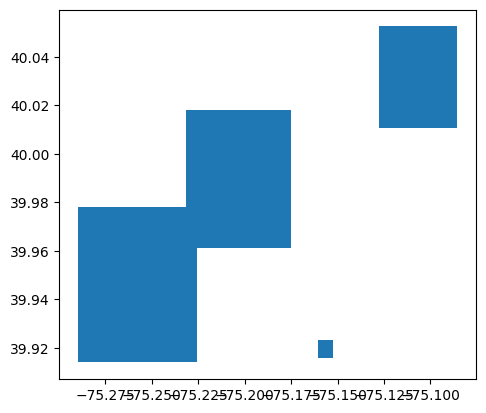

In [29]:
all_boxes_gdf.plot()

### Filtering points in each park

In [212]:
## filter points in parks
illegal_dumping_parks = illegal_dumping.sjoin(all_boxes_gdf, predicate='within')

In [196]:
tacony_points = illegal_dumping_parks[illegal_dumping_parks['PARKNAME'] == 'tacony_box']

In [197]:
tacony_points.shape

(2670, 21)

### jittering time

In [213]:
# Create time windows throughout the day
time_windows = [
    (0, 14400),      # 12am-4am
    (14400, 28800),  # 4am-8am
    (28800, 43200),  # 8am-12pm
    (43200, 57600),  # 12pm-4pm
    (57600, 72000),  # 4pm-8pm
    (72000, 86400)   # 8pm-12am
]

# Calculate how many points to assign to each window
points_per_window = len(illegal_dumping_parks) // len(time_windows)
remaining_points = len(illegal_dumping_parks) % len(time_windows)

# Generate jittered times
jittered_times = []
for i, (start, end) in enumerate(time_windows):
    # Add extra points to first few windows if we have remainder
    n_points = points_per_window + (1 if i < remaining_points else 0)
    # Generate uniform random times within this window
    window_times = np.random.uniform(start, end, n_points)
    jittered_times.extend(window_times)

# Shuffle the times to avoid any ordering
np.random.shuffle(jittered_times)

# Apply the jittered times
illegal_dumping_parks['jittered_time'] = illegal_dumping_parks['requested_'] + \
    pd.to_timedelta(jittered_times, unit='s')

# get coordinates from the geometry
coords = pd.DataFrame({
    'x': illegal_dumping_parks.geometry.centroid.x,
    'y': illegal_dumping_parks.geometry.centroid.y
})

# calculate time difference in days from the minimum date
min_time = illegal_dumping_parks['jittered_time'].min()
time_diff = (illegal_dumping_parks['jittered_time'] - min_time).dt.total_seconds() / (24 * 60 * 60)
illegal_dumping_parks['time_diff'] = time_diff

# Create locs_s DataFrame
locs_s = pd.DataFrame({
    'X': coords['x'].astype(float),
    'Y': coords['y'].astype(float),
    'T': time_diff.astype(float)
})

/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_4079/2852038095.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'x': illegal_dumping_parks.geometry.centroid.x,
/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_4079/2852038095.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  'y': illegal_dumping_parks.geometry.centroid.y


In [214]:
# Calculate time differences between consecutive points
locs_s = locs_s.sort_values('T')
time_diffs = locs_s['T'].diff().fillna(0)

# Create jitter that's proportional to the time differences
# Use a fraction of the time difference as the jitter amount
jitter_fraction = 0.1  # Jitter will be 10% of the time difference
jitter = np.random.normal(0, time_diffs * jitter_fraction)

# Apply the jitter
locs_s['T'] = locs_s['T'] + jitter

# Ensure no negative times
locs_s['T'] = locs_s['T'].clip(lower=0)

# Sort by time again
locs_s = locs_s.sort_values('T')

# Reset index
locs_s = locs_s.reset_index(drop=True)

## Quality check

### Event distribution after jittering

/var/folders/nr/q7sysy9j07x_5smd2gfx3j380000gn/T/ipykernel_4079/2560777803.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Year')


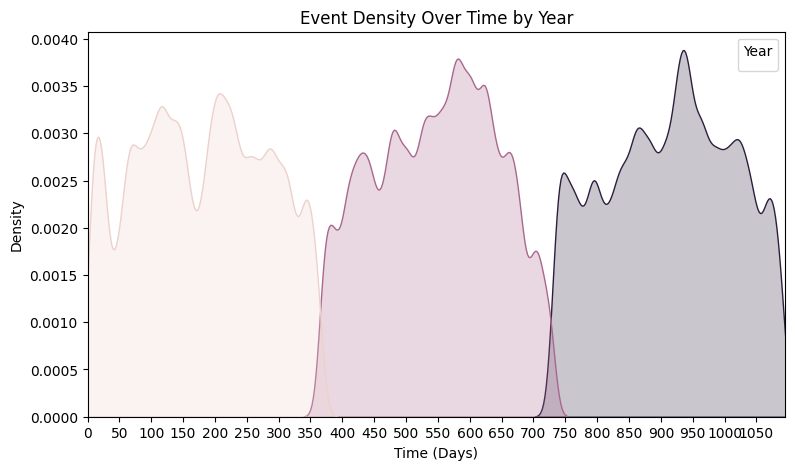

In [219]:
# get year
illegal_dumping_parks['year'] = pd.to_datetime(illegal_dumping_parks['requested_']).dt.year

start_date = illegal_dumping_parks['requested_'].min()
illegal_dumping_parks['days_since_start'] = (
    illegal_dumping_parks['requested_'] - start_date
).dt.days

plt.figure(figsize=(9, 5))
sns.kdeplot(
    data=illegal_dumping_parks,
    x='days_since_start',  # Now numeric!
    hue='year',
    common_norm=False,
    bw_adjust=0.5,
    fill=True
)

plt.xlabel('Time (Days)')
plt.ylabel('Density')
plt.title('Event Density Over Time by Year')
plt.xlim(0, 1095)  # Now this will work correctly
plt.xticks(np.arange(0, 1100, 50))
plt.legend(title='Year')
plt.show()

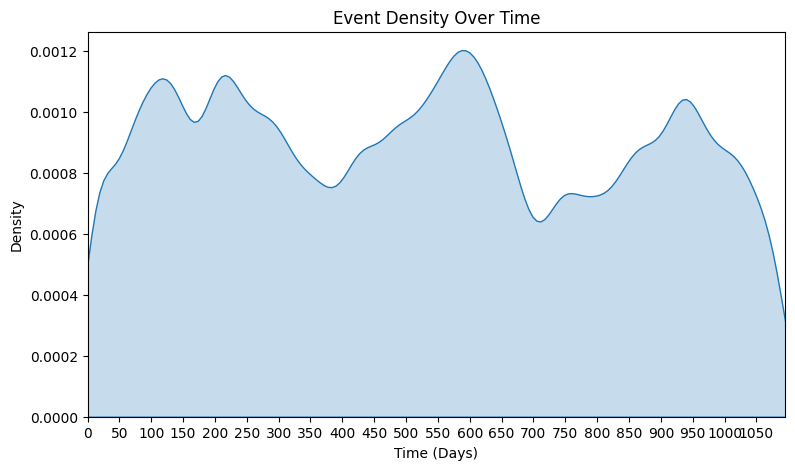

In [220]:
plt.figure(figsize=(9, 5))

sns.kdeplot(
    data=illegal_dumping_parks,
    x='days_since_start',  # Use the days variable
    bw_adjust=0.5,         # Adjust smoothness
    fill=True              # Fill under the curve
)

plt.xlabel('Time (Days)')
plt.ylabel('Density')
plt.title('Event Density Over Time')
plt.xlim(0, 1095)
plt.xticks(np.arange(0, 1100, 50))

plt.show()

### Reversed time points

In [201]:
locs_s.shape

(2670, 3)

## Model fitting

In [202]:
## Cox-Hawkes model
# a_0 = baseline log-intensity
# alpha = magnitute of excitation
# bate = temporal trigger param
# sigmax_2 = spatial trigger param
model = Hawkes_Model(locs_s,#spatiotemporal points
                     all_boxes_gdf[all_boxes_gdf['PARKNAME']=='tacony_box'],#philly boundaries
                     1095,#Time frame 
                     True,#use Cox as background
#                     spatial_cov=data['covariates'],#spatial covariate matrix
#                     cov_names = column_names,#columns to use from covariates
                     a_0=dist.Normal(0,2), 
                     # alpha = dist.Beta(20,60),#set priors
                     alpha = dist.Beta(2,2),
                     # beta=dist.HalfNormal(2.0),
                     beta=dist.HalfNormal(1.0),
                     sigmax_2=dist.HalfNormal(0.25)
                    )

/Users/yuxin/BSTPP/bstpp/main.py:114: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  #proportion of area of rectangle A_ covered by A. Used for Hawkes integral.


[DEBUG] set_window called with:
  window type: <class 'float'> value: 12.0
  spatial_window type: <class 'float'> value: 0.25
[DEBUG] aligned_difference_pairs called with:
  t type: <class 'numpy.ndarray'> dtype: float64 shape: (2670,)
  x type: <class 'numpy.ndarray'> dtype: float64 shape: (2670,)
  y type: <class 'numpy.ndarray'> dtype: float64 shape: (2670,)
  window type: <class 'float'> value: 12.0
  spatial_window type: <class 'float'> value: 0.25
[set_window] Temporal window set to: 12.0
[set_window] Number of events: 2670
[set_window] Number of pairs: 299108
[set_window] Max t_diff in pairs: 11.999978310191723
[set_window] Min t_diff in pairs: 4.785058763445704e-06
[set_window] All t_diff <= window: True
[set_window] All t_diff > 0: True
[set_window] Spatial window set to: 0.25
[set_window] Max spatial distance: 0.24999940395355225
[set_window] Min spatial distance: 0.0
[set_window] All spatial distances <= window: True


100%|██████████| 5000/5000 [00:19<00:00, 251.25it/s, init loss: -7900.6665, avg. loss [4751-5000]: -24108.7201]


Number of posterior samples: 1000
Number of pairs: 299108
coords shape: (299108, 2)

SVI elapsed time: 24.553091049194336


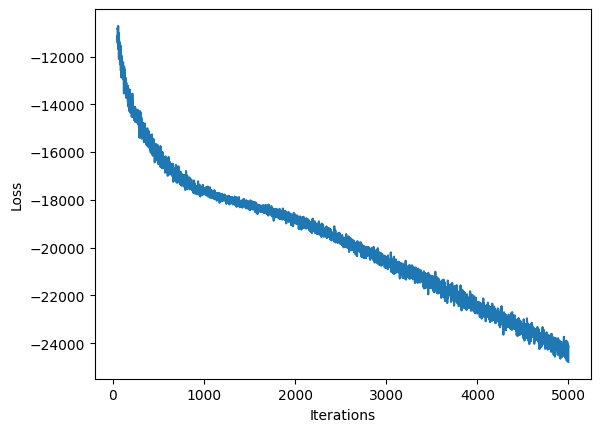

In [203]:
model.set_window(window = 12, spatial_window= 0.25)
model.run_svi(lr=0.005,num_steps=5000) # less interations and bigger learning rate

## Reults

In [204]:
model.log_expected_likelihood(locs_s)

12512.7578125

In [205]:
model.expected_AIC()

-24353.919921875

0.6018297672271729

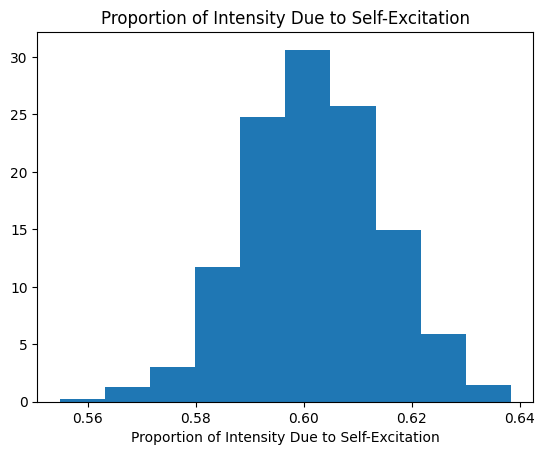

In [206]:
model.plot_prop_excitation()

,Post Mean,Post Std,P(w>0),[0.025,0.975]
alpha,0.634431,0.017647,1.0,0.599502,0.668735
beta,2.542256,0.091511,1.0,2.356784,2.731967
sigmax_2,0.000023,0.000003,1.0,0.000018,0.000030


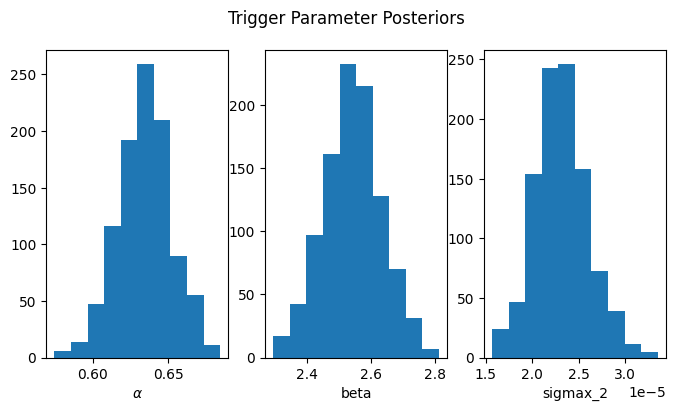

In [207]:
model.plot_trigger_posterior(trace=False)

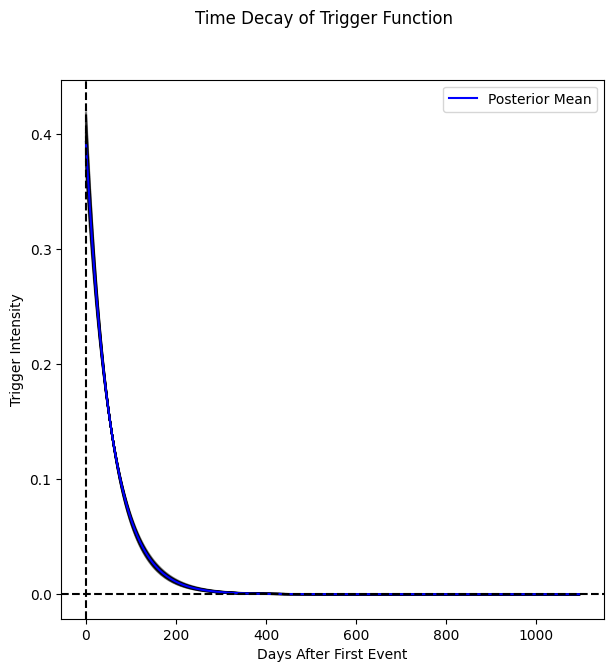

<Figure size 640x480 with 0 Axes>

In [208]:
model.plot_trigger_time_decay()
plt.gcf()

# Show the plot
plt.show()

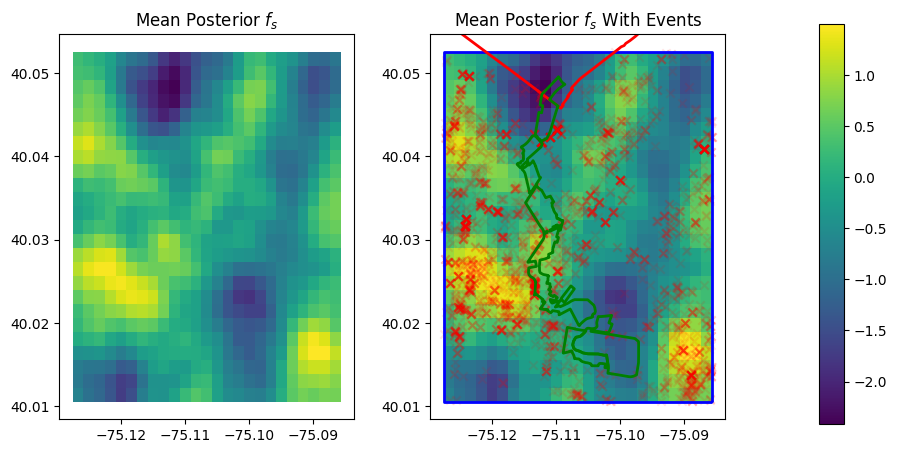

In [209]:
model.plot_spatial(include_cov=False)

# Get all axes in the figure
fig = plt.gcf()
axs = fig.get_axes()

# Match limits from left subplot
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

# Try plotting on the second subplot (with events)
all_boxes_gdf.plot(ax=axs[1], edgecolor='blue', facecolor='none', linewidth=2)
philly_border.plot(ax=axs[1], edgecolor='red', facecolor='none', linewidth=2)
all_parks_gdf.plot(ax=axs[1], edgecolor='green', facecolor='none', linewidth=2)


# Set the same limits on the right subplot
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

# Save and show
plt.savefig('output/spatial_trigger_tcn.png', dpi=450, bbox_inches='tight')
plt.show()

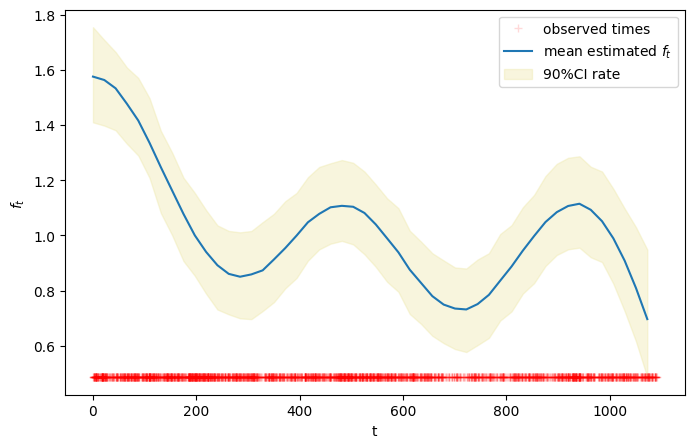

In [210]:
model.plot_temporal()
#plt.gcf().savefig('output/temporal_tcn.png', 
#                 dpi=450,
#                 bbox_inches='tight')

# Show the plot
plt.show()